# Exercise 2: 1D Magnetodynamics (Time-Harmonic)

In [1]:
include(joinpath(dirname(@__DIR__), "config.jl"))
paths = get_project_paths("examples")

# Ensure the module is reloaded if changed
if isdefined(Main, :MagnetostaticsFEM)
    println("Reloading MagnetostaticsFEM...")
    # A simple way to force reload in interactive sessions
    try; delete!(LOAD_PATH, joinpath(paths["SRC_DIR"], "src")); catch; end
    try; delete!(Base.loaded_modules, Base.PkgId(Base.UUID("f8a2b3c4-d5e6-f7a8-b9c0-d1e2f3a4b5c6"), "MagnetostaticsFEM")); catch; end
end
include(joinpath(paths["SRC_DIR"], "MagnetostaticsFEM.jl"))

using LinearAlgebra
using Plots
using LaTeXStrings
using Gridap
using .MagnetostaticsFEM
using Printf # For animation title formatting

┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.WeakFormProblem :: Union{}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetostatics_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_harmonic_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_harmonic_coupled_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.define_reluctivity :: Tuple{Dict{S

## Define Parameters and Paths

In [2]:
# Model Parameters
J0 = 2.2e4       # Source current density [A/m²] (Assumed Real)
μ0 = 4e-7 * pi  # Vacuum permeability [H/m]
μr_core = 50000.0 # Relative permeability of the core
σ_core = 1e7    # Conductivity of the core [S/m]
freq = 50    # Frequency [Hz]
ω = 2 * pi * freq # Angular frequency [rad/s]

# FEM Parameters
order = 2
field_type = ComplexF64 # Still use ComplexF64 marker for setup_fe_spaces
dirichlet_tag = "D"
dirichlet_value = 0.0 + 0.0im # Dirichlet BC for A = u + iv

# Paths
mesh_file = joinpath(paths["GEO_DIR"], "coil_geo.msh")
output_file_base = joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_coupled")

println("Mesh file: ", mesh_file)
println("Output directory: ", paths["OUTPUT_DIR"])

Mesh file: c:\Users\Martin\FutureDistributionSystemsAM\examples\geo\coil_geo.msh
Output directory: c:\Users\Martin\FutureDistributionSystemsAM\examples\output


## Setup FEM Problem

In [3]:
# Load mesh and tags
model, labels, tags = load_mesh_and_tags(mesh_file)

# Get material tags dictionary
material_tags = get_material_tags(labels)

# Set up triangulation and measures
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)

# Define material property functions
reluctivity_func = define_reluctivity(material_tags, μ0, μr_core)
conductivity_func = define_conductivity(material_tags, σ_core)
source_current_func = define_current_density(material_tags, J0) # Real source

# Setup FE spaces (multi-field: Real, Imag parts)
U, V = setup_fe_spaces(model, order, field_type, dirichlet_tag, dirichlet_value)

# Define the weak form problem for the coupled system
problem = magnetodynamics_harmonic_coupled_weak_form(Ω, dΩ, tags, reluctivity_func, conductivity_func, source_current_func, ω)

Info    : Reading 'c:\Users\Martin\FutureDistributionSystemsAM\examples\geo\coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'c:\Users\Martin\FutureDistributionSystemsAM\examples\geo\coil_geo.msh'
Setting up multi-field spaces (Real, Imag) for Complex problem.


WeakFormProblem(Main.MagnetostaticsFEM.var"#a#39"{Gridap.CellData.GenericMeasure, Float64, Gridap.CellData.OperationCellField{ReferenceDomain}, Gridap.CellData.OperationCellField{ReferenceDomain}}(GenericMeasure(), 314.1592653589793, OperationCellField(), OperationCellField()), Main.MagnetostaticsFEM.var"#b#40"{Gridap.CellData.GenericMeasure, Gridap.CellData.OperationCellField{ReferenceDomain}}(GenericMeasure(), OperationCellField()))

## Solve FEM Problem

In [4]:
# Solve the real coupled linear FE system
uv = solve_fem_problem(problem, U, V) # uv is a MultiFieldFEFunction

# Extract real and imaginary parts
u = uv[1] # Real part of Az
v = uv[2] # Imag part of Az
println("u = ", u)

u = SingleFieldFEFunction()


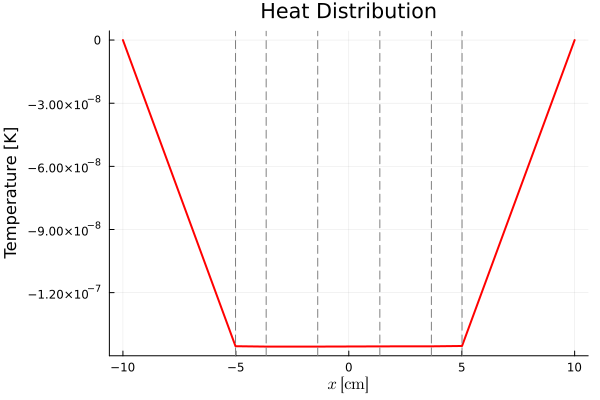

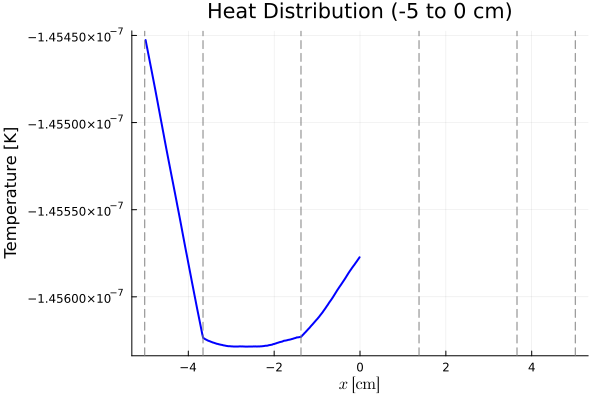

Setting up single-field space.


"c:\\Users\\Martin\\FutureDistributionSystemsAM\\examples\\output\\heat_distribution_zoom_-5to0cm.pdf"

In [5]:
"""
    define_loss_density(material_tags::Dict{String, Int}, J_eddy_re, J_eddy_im, σ_core; core_tag_name="Core")

Returns a function `loss_density(tag)` that maps a material tag to its eddy current loss density (W/m³).
Loss density is calculated as ρJ²/2 where ρ = 1/σ and J is the RMS eddy current density.
"""
function define_loss_density(material_tags::Dict{String, Int}, J_eddy_re, J_eddy_im, σ_core; core_tag_name="Core")
    # Get the core tag ID
    core_tag = get(material_tags, core_tag_name, -1)
    
    # Define the mapping function
    function loss_density(tag)
        if tag == core_tag
            # For core material, calculate losses
            ρ = 1 / σ_core
            J_re = J_eddy_re
            J_im = J_eddy_im
            J_rms_squared = (J_re^2 + J_im^2) / 2
            return ρ * J_rms_squared
        else
            # For non-core materials, no losses
            return 0.0
        end
    end
    
    return loss_density
end


Ω_loss = Triangulation(model)
dΩ_loss = Measure(Ω_loss, 2*order)
thermal_conductivity_coil = 5.8  # Thermal conductivity of the coil material [W/(m·K)]
thermal_conductivity_core = 45.0  # Thermal conductivity of the core material [W/(m·K)]
thermal_conductivity_air = 0.025  # Thermal conductivity of air [W/(m·K)]

room_temperature = 293.0  # Room temperature in K
dirichlet_value = room_temperature

material_tags = get_material_tags(labels)
# conductivity_func = define_conductivity(material_tags, σ_core)
conductivity_func = define_heat_conductivity(material_tags, thermal_conductivity_coil, thermal_conductivity_core, thermal_conductivity_air)

# Compute the eddy current losses from the magnetodynamic solution uv
J_eddy_re, J_eddy_im = calculate_eddy_current(uv, conductivity_func, ω, Ω_loss, tags)

# Define helper functions for magnitude squared
mag_sq_scalar(re, im) = re * re + im * im
mag_sq_vector(re, im) = inner(re, re) + inner(im, im)
material_tags = Dict("Core" => 1, "Coil1" => 2, "Coil2" => 3, "Air" => 4)
material_tages = get_material_tags(labels)
loss_density_func = define_loss_density(material_tags, J_eddy_re, J_eddy_im, σ_core)

source_current_func = define_current_density(material_tags, J0)
uv_heat = solve_heatdynamics(model, tags, order, dirichlet_tag, dirichlet_value, 
    loss_density_func, conductivity_func)

# Evaluate and visualize the heat distribution (temperature field)
x_int_heat = collect(range(-0.1, 0.1, length=1000))
coord_heat = [VectorValue(x) for x in x_int_heat]

# Evaluate the temperature field at the interpolation points
theta_vals = uv_heat(coord_heat) .- 293.0

p_heat = plot(x_int_heat*1e2, theta_vals, xlabel=L"x\ \mathrm{[cm]}", ylabel="Temperature [K]",
    lw=2, color=:red, legend=false, title="Heat Distribution")
if !(@isdefined boundaries)
    a_len = 100.3e-3; b_len = 73.15e-3; c_len = 27.5e-3
    xa1 = -a_len/2; xb1 = -b_len/2; xc1 = -c_len/2
    xc2 = c_len/2; xb2 = b_len/2; xa2 = a_len/2
    boundaries = [xa1, xb1, xc1, xc2, xb2, xa2]
end
vline!(p_heat, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
display(p_heat)
savefig(p_heat, joinpath(paths["OUTPUT_DIR"], "heat_distribution.pdf"))

# Plot only between -5 and 0 cm
mask = (x_int_heat .>= -0.05) .& (x_int_heat .<= 0.0)
x_zoom = x_int_heat[mask]
theta_zoom = theta_vals[mask]

p_heat_zoom = plot(x_zoom*1e2, theta_zoom, xlabel=L"x\ \mathrm{[cm]}", ylabel="Temperature [K]",
    lw=2, color=:blue, legend=false, title="Heat Distribution (-5 to 0 cm)")
vline!(p_heat_zoom, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
display(p_heat_zoom)
savefig(p_heat_zoom, joinpath(paths["OUTPUT_DIR"], "heat_distribution_zoom_-5to0cm.pdf"))

## Post-processing

In [6]:
# Compute B-field (Real and Imag parts)
B_re, B_im = calculate_b_field(uv)

# Compute Eddy Currents (Real and Imag parts)
J_eddy_re, J_eddy_im = calculate_eddy_current(uv, conductivity_func, ω, Ω, tags)

# Define helper functions for magnitude squared
mag_sq_scalar(re, im) = re*re + im*im
mag_sq_vector(re, im) = inner(re, re) + inner(im, im)

# Calculate Magnitudes for saving/plotting using composition
Az_mag = sqrt ∘ (mag_sq_scalar ∘ (u, v))
B_mag = sqrt ∘ (mag_sq_vector ∘ (B_re, B_im))
Jeddy_mag = sqrt ∘ (mag_sq_scalar ∘ (J_eddy_re, J_eddy_im))

# Save results to VTK format
save_results_vtk(Ω, output_file_base, 
    Dict(
        "Az_re" => u, "Az_im" => v, "Az_mag" => Az_mag,
        "B_re" => B_re, "B_im" => B_im, "B_mag" => B_mag,
        "Jeddy_re" => J_eddy_re, "Jeddy_im" => J_eddy_im, "Jeddy_mag" => Jeddy_mag
    ))

Saving results to single VTK file...
Error saving single VTK file: UndefVarError(:writevtk)
Attempting to save components individually...
Failed to save component B_re. Error: UndefVarError(:writevtk)
Failed to save component Az_re. Error: UndefVarError(:writevtk)
Failed to save component Az_mag. Error: UndefVarError(:writevtk)
Failed to save component B_mag. Error: UndefVarError(:writevtk)
Failed to save component Jeddy_re. Error: UndefVarError(:writevtk)
Failed to save component Az_im. Error: UndefVarError(:writevtk)
Failed to save component Jeddy_im. Error: UndefVarError(:writevtk)
Failed to save component B_im. Error: UndefVarError(:writevtk)
Failed to save component Jeddy_mag. Error: UndefVarError(:writevtk)


## Visualization (Magnitudes)

In [7]:
# Define geometry boundaries for plotting
a_len = 100.3e-3; b_len = 73.15e-3; c_len = 27.5e-3
xa1 = -a_len/2; xb1 = -b_len/2; xc1 = -c_len/2
xc2 = c_len/2; xb2 = b_len/2; xa2 = a_len/2
boundaries = [xa1, xb1, xc1, xc2, xb2, xa2]

6-element Vector{Float64}:
 -0.05015
 -0.036575
 -0.01375
  0.01375
  0.036575
  0.05015

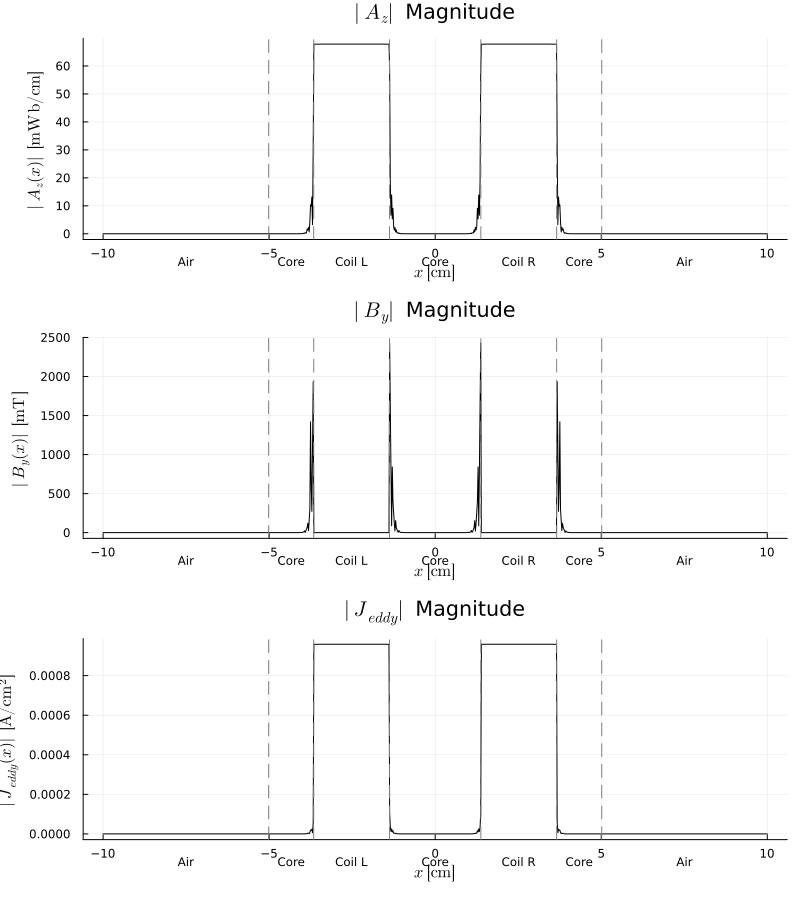

In [8]:
# Define points for visualization
x_int = collect(range(-0.1, 0.1, length=1000))
coord = [VectorValue(x_) for x_ in x_int]

# Evaluate magnitudes at interpolation points
Az_mag_vals = Az_mag(coord)
B_mag_vals = B_mag(coord)
Jeddy_mag_vals = Jeddy_mag(coord)

# Calculate midpoints for region labels
x_min_plot = minimum(x_int); x_max_plot = maximum(x_int)
midpoints = [(x_min_plot + xa1)/2, (xa1 + xb1)/2, (xb1 + xc1)/2, (xc1 + xc2)/2, (xc2 + xb2)/2, (xb2 + xa2)/2, (xa2 + x_max_plot)/2]
region_labels = ["Air", "Core", "Coil L", "Core", "Coil R", "Core", "Air"]

# Plot Magnitudes
p1 = plot(x_int * 1e2, Az_mag_vals * 1e5, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|A_z(x)|\ \mathrm{[mWb/cm]}", color=:black, lw=1, legend=false, title=L"|A_z|" *" Magnitude")
p2 = plot(x_int * 1e2, B_mag_vals * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|B_y(x)|\ \mathrm{[mT]}", color=:black, lw=1, legend=false, title=L"|B_y|" *" Magnitude")
p3 = plot(x_int * 1e2, Jeddy_mag_vals * 1e-4, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|J_{eddy}(x)|\ \mathrm{[A/cm^2]}", color=:black, lw=1, legend=false, title=L"|J_{eddy}|" *" Magnitude")

# Add annotations
for p in [p1, p2, p3]
    vline!(p, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
    plot_ylims = Plots.ylims(p)
    label_y = plot_ylims[1] - 0.08 * (plot_ylims[2] - plot_ylims[1])
    annotate!(p, [(midpoints[i]*1e2, label_y, text(region_labels[i], 8, :center, :top)) for i in eachindex(midpoints)])
end

plt_mag = plot(p1, p2, p3, layout=(3,1), size=(800, 900))
savefig(plt_mag, joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_coupled_magnitudes.pdf"))
display(plt_mag)

## Visualization (Animation)

Plots.AnimatedGif("c:\\Users\\Martin\\FutureDistributionSystemsAM\\examples\\output\\magnetodynamics_harmonic_coupled_animation(f=5.00e+01).gif")
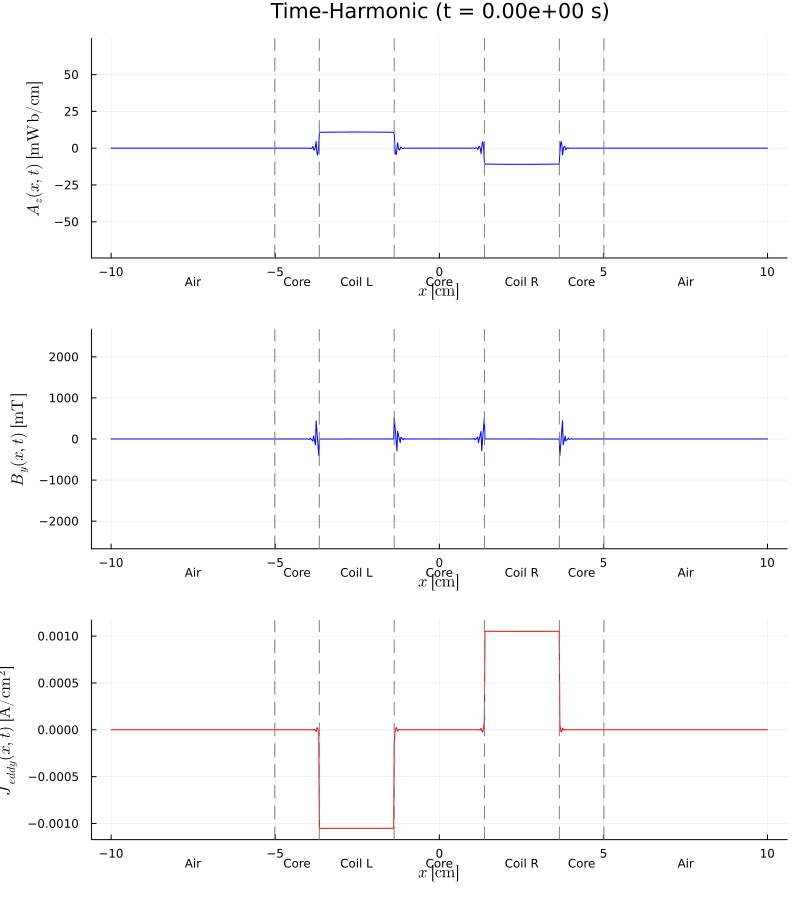

┌ Info: Saved animation to c:\Users\Martin\FutureDistributionSystemsAM\examples\output\magnetodynamics_harmonic_coupled_animation(f=5.00e+01).gif
└ @ Plots C:\Users\Martin\.julia\packages\Plots\dIjan\src\animation.jl:156


In [ ]:
# Create animation over one period
T_period = 1/freq
t_vec = range(0, T_period, length=100)

anim = @animate for t_step in t_vec
    # Calculate instantaneous real value: Re( (u+iv) * exp(jωt) ) = u*cos(ωt) - v*sin(ωt)
    cos_wt = cos(ω * t_step)
    sin_wt = sin(ω * t_step)
    
    Az_inst = u * cos_wt - v * sin_wt
    B_re_inst = B_re * cos_wt - B_im * sin_wt # Instantaneous B_re
    # B_im_inst = B_re * sin_wt + B_im * cos_wt # Instantaneous B_im (not needed for By)
    Jeddy_inst = J_eddy_re * cos_wt - J_eddy_im * sin_wt
    
    # Evaluate at interpolation points
    Az_inst_vals = Az_inst(coord)
    B_re_inst_vals = B_re_inst(coord)
    By_inst_vals = [b[1] for b in B_re_inst_vals] # Extract y-component
    Jeddy_inst_vals = Jeddy_inst(coord)
    
    # Get magnitude limits for consistent y-axis scaling
    Az_max = maximum(Az_mag_vals)
    By_max = maximum(B_mag_vals)
    Jeddy_max = maximum(Jeddy_mag_vals)

    # Plot instantaneous real parts at time t
    p1_t = plot(x_int * 1e2, Az_inst_vals * 1e5, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"A_z(x,t)\ \mathrm{[mWb/cm]}", color=:blue, lw=1, legend=false, title=@sprintf("Time-Harmonic (t = %.2e s)", t_step), ylims=(-Az_max*1.1e5, Az_max*1.1e5))
    p2_t = plot(x_int * 1e2, By_inst_vals * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"B_y(x,t)\ \mathrm{[mT]}", color=:blue, lw=1, legend=false, ylims=(-By_max*1.1e3, By_max*1.1e3))
    p3_t = plot(x_int * 1e2, Jeddy_inst_vals * 1e-4, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"J_{eddy}(x,t)\ \mathrm{[A/cm^2]}", color=:red, lw=1, legend=false, ylims=(-Jeddy_max*1.1e-4, Jeddy_max*1.1e-4))

    # Add annotations
    for p in [p1_t, p2_t, p3_t]
        vline!(p, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
        plot_ylims = Plots.ylims(p)
        label_y = plot_ylims[1] - 0.08 * (plot_ylims[2] - plot_ylims[1])
        annotate!(p, [(midpoints[i]*1e2, label_y, text(region_labels[i], 8, :center, :top)) for i in eachindex(midpoints)])
    end
    
    plot(p1_t, p2_t, p3_t, layout=(3,1), size=(800, 900))
end

gif(anim, joinpath(paths["OUTPUT_DIR"], @sprintf("magnetodynamics_harmonic_coupled_animation(f=%.2e).gif", freq)), fps = 15)